In [1]:
# Collect imports here
import sys, os
from time import sleep, time
import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

# Choose the factor to be reviewed, either whole price or price per square meter
#factor = "Velaton hinta"
factor = "Neliöhinta"

In [2]:
# Read the data
today = datetime.date.today()

#today = today - datetime.timedelta(days=1) #Possibility to use yesterdays data
today_str = str(today)

ROOT_DIR = os.path.dirname(os.path.abspath(''))
csv_path = os.path.join(os.path.sep, ROOT_DIR + '/JodaAIPlatformEnv/resultfiles'+ os.sep +"apartments_cleaned" + today_str + ".csv")

cols = [factor, "Alue", "Pinta-ala", "Yhtiövastike", "Kerroslukema", "Sauna", "Parveke"]

df_og = pd.read_csv(csv_path, sep=";", usecols=cols)

# Create working copy from the dataframe
df = df_og

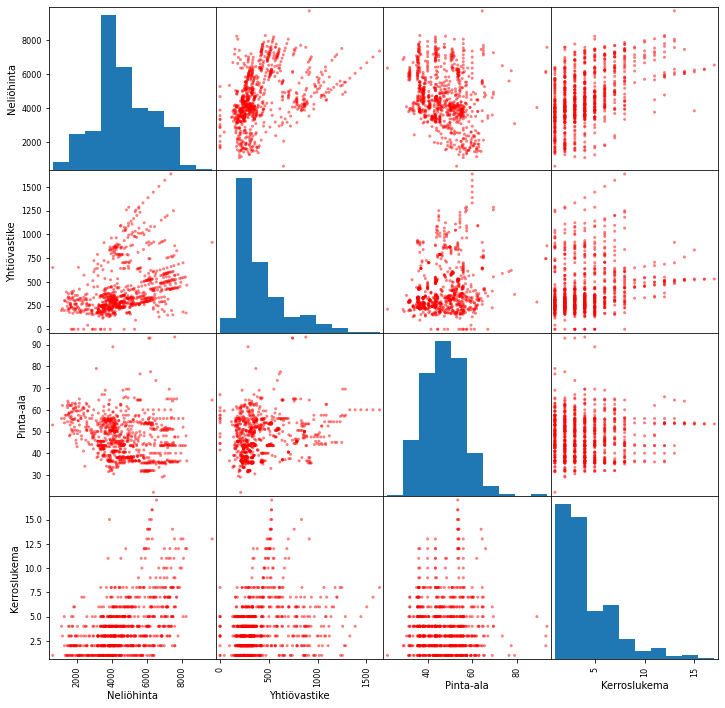

In [3]:
# Create scatter plot to visualize and explore data
scattercols = [factor,'Yhtiövastike', 'Pinta-ala', 'Kerroslukema']
axs = pd.plotting.scatter_matrix(df[scattercols],
                        figsize=(12, 12), c='red')

In [4]:
display(df)

,Alue,Pinta-ala,Neliöhinta,Yhtiövastike,Parveke,Sauna,Kerroslukema
0,Santalahti,38.0,4784.21,278.81,True,False,2.0
1,Hatanpää,50.0,4980.00,410.50,True,True,7.0
2,Tampereen keskusta,47.5,6631.58,180.50,True,True,4.0
3,Rantaperkiö,49.5,3616.16,216.90,True,True,3.0
4,Hakametsä,53.5,3252.34,209.06,True,False,3.0
...,...,...,...,...,...,...,...
864,Santalahti,44.0,4693.18,312.14,True,False,3.0
865,Santalahti,44.0,4543.18,291.48,True,False,2.0
866,Lintuhytti,39.0,3512.82,209.04,True,False,2.0
867,Haukiluoma,51.0,1666.67,234.60,True,False,3.0


In [5]:
# get feature encoding for categorical variables
region_dummies = pd.get_dummies(df["Alue"])


# convert boolean columns to a single boolean value indicating whether this listing has instant booking available
sauna_dummies = pd.get_dummies(df["Sauna"], prefix="Sauna")
sauna_dummies = sauna_dummies.drop('Sauna_False', axis=1)

parveke_dummies = pd.get_dummies(df["Parveke"], prefix="Parveke")
parveke_dummies = parveke_dummies.drop('Parveke_False', axis=1)

# Connect all the data together
alldata = pd.concat((df.drop(['Alue', 'Sauna', 'Parveke'], axis=1), \
                     region_dummies.astype(int), \
                     sauna_dummies.astype(int), \
                     parveke_dummies.astype(int)), \
                    axis=1)

# Verify that the data is as we want it to be
display(alldata.columns)
display(alldata)

alldata = alldata.dropna()

display(df.shape)

Index(['Pinta-ala', 'Neliöhinta', 'Yhtiövastike', 'Kerroslukema',
       'Ala-Pispala', 'Amuri', 'Annala', 'Armonkallio', 'Epilä', 'Haapalinna',
       'Hakametsä', 'Halkoniemi', 'Hatanpää', 'Haukiluoma', 'Hervanta',
       'Huikas', 'Hyhky', 'Hämeenpuisto', 'Härmälä', 'Härmälänranta', 'Irjala',
       'Janka', 'Järvensivu', 'Kaakinmaa', 'Kaleva', 'Kalkku', 'Kaukajärvi',
       'Kauppi', 'Keskusta', 'Kissanmaa', 'Koivistonkylä', 'Lahdesjärvi',
       'Lamminpää', 'Lappi', 'Leinola', 'Lentävänniemi', 'Lielahti',
       'Linnainmaa', 'Lintuhytti', 'Lukonmäki', 'Maisansalo', 'Messukylä',
       'Multisilta', 'Muotiala', 'Nalkala', 'Nekala', 'Niemenranta',
       'Palokallio', 'Pappila', 'Peltolammi', 'Peltolammi/Palokallio',
       'Pispala', 'Pohtola', 'Pyynikki', 'Rahola', 'Ranta-Tampella',
       'Rantaperkiö', 'Ratina', 'Rautaharkko', 'Ristimäki', 'Ruotula',
       'Santalahti', 'Tahmela', 'Takahuhti', 'Tammela', 'Tampella',
       'Tampereen keskusta', 'Tesoma', 'Veisu', 'Viiala', 'V

,Pinta-ala,Neliöhinta,Yhtiövastike,Kerroslukema,Ala-Pispala,Amuri,Annala,Armonkallio,Epilä,Haapalinna,...,Tampella,Tampereen keskusta,Tesoma,Veisu,Viiala,Viinikka,Villilä,Vuores,Sauna_True,Parveke_True
0,38.0,4784.21,278.81,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,50.0,4980.00,410.50,7.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,47.5,6631.58,180.50,4.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
3,49.5,3616.16,216.90,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,53.5,3252.34,209.06,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,44.0,4693.18,312.14,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
865,44.0,4543.18,291.48,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
866,39.0,3512.82,209.04,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
867,51.0,1666.67,234.60,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(869, 7)

got error 413.20
got error 403.88
got error 398.81
got error 704.95
got error 401.02
got error 558.43


Text(0, 0.5, 'Median Absolute Error')

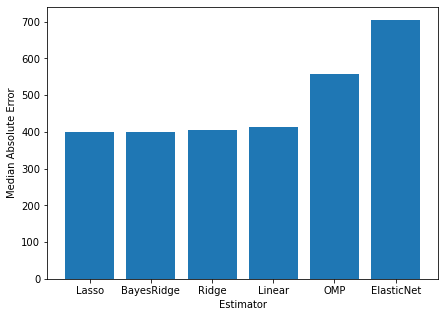

In [6]:
# Test different estimators with the data

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop([factor], axis=1),
                                                    alldata[factor], test_size=0.2, random_state=20)


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print( "got error %0.2f" % this_err)
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [7]:
# Test an ensemble method, GridSearchCV with 3000 estimations

n_est = 3000

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

In [8]:
# Show best estimator settings and error with them
display(best)

err = metrics.median_absolute_error(y_test, clf.predict(X_test))
display(err)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='lad',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=1.0,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

436.1812362277774

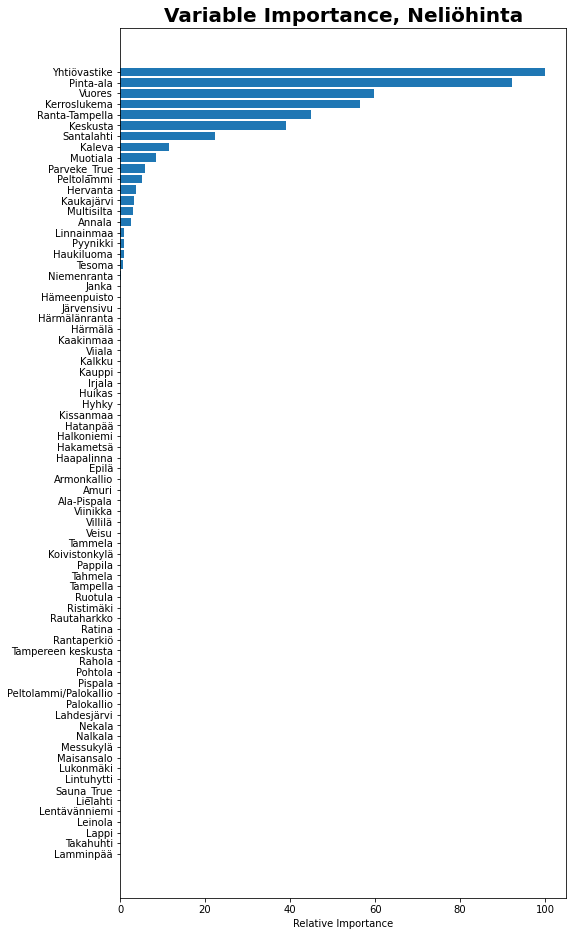

In [9]:
# Plot feature importance

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,16))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance, ' + factor, weight='bold', size=20)

plt.savefig(ROOT_DIR + '/JodaAIPlatformEnv/Visualizations/Variable_importance_'+ factor +'.png')

Text(0, 0.5, 'Least Absolute Deviation')

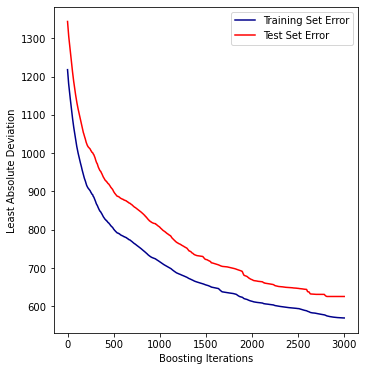

In [10]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')